## Calculate upwelling longwave radiation

#### R<sub>LU</sub> = 𝜎𝜀<sub>S</sub>𝑇<sub>S</sub><sup>4</sup>

𝜎 is 5.67 × 10<sup>-8</sup> J s<sup>-1</sup> m<sup>-2</sup> K<sup>-4</sup><br>
𝜀<sub>S</sub> is Emissivity from MOD11L2<br>
𝑇<sub>S</sub> is AHI LST

In [59]:
import xarray
import gzip
import numpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.ticker as tck

In [7]:
# date time: UTC 2018-08-01 03:00:00
emis_filename = '/disk2/Data/MOD11L2_Emissivity/MOD11A1.061_Emis_31_doy2018213_aid0001.tif'
lst_filename = '/disk2/Data/AHILST_YY/201808/AHILST.v0.201808010300.dat.gz'

In [8]:
# study extent
resolution = 0.01 # degree
lats = numpy.arange(47.5-resolution/2, 22.5, -resolution)
lons = numpy.arange(120.+resolution/2, 150, resolution)

In [56]:
def read_emis(modis_emis_tif):
    modis_ds = xarray.open_rasterio(modis_emis_tif)[0]
    jp_ds = modis_ds.interp(x=lons, y=lats, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
    emis_dn = numpy.array(jp_ds.values)
    emis_dn[emis_dn==0] = numpy.NaN
    data_v = emis_dn*0.002+0.49
    return data_v


def read_lst_k(ahi_lst_gz, resolution=0.02):
    with gzip.open(ahi_lst_gz, 'rb') as file:
        gz_data = file.read()
        lst_data = numpy.copy(numpy.frombuffer(gz_data, dtype='f4').reshape(1500, 1500)) # 0.02°
        lst_ds = xarray.Dataset(
            data_vars={
                "values": (("y", "x"), lst_data),
            },
            coords={
                "y": numpy.arange(50-resolution/2, 20, -resolution),
                "x": numpy.arange(120.+resolution/2, 150, resolution)
            },
        )
        jp_ds = lst_ds.interp(x=lons, y=lats, method="nearest", kwargs={"fill_value": "extrapolate"}) # linear
        lst_v = numpy.array(jp_ds.to_array()[0])
        lst_v[lst_v==-999] = numpy.NaN
        lst_data = lst_v + 273 # ℃ -> K
        return lst_data

    
def calculate_r_lu(epsilon_s, t_s):
    sigma = 5.67e-8
    r_lu = sigma * epsilon_s * t_s**4
    return r_lu

In [57]:
modis_emis = read_emis(emis_filename)
ahi_lst = read_lst_k(lst_filename)
r_lu = calculate_r_lu(modis_emis, ahi_lst)

Text(0.5, 1.0, 'R$_{LU}$ at 2018-08-01 UTC3:00:00')

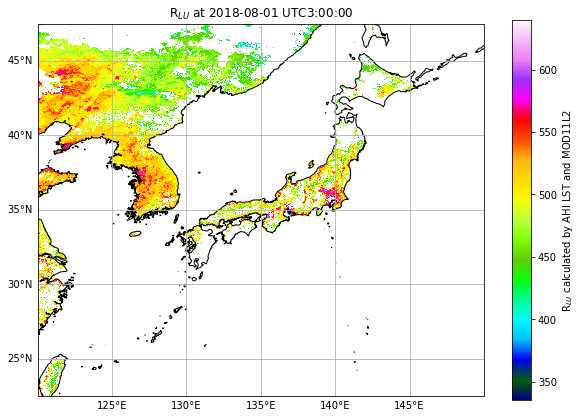

In [72]:
r_lu_show = numpy.copy(r_lu)

plt.figure(figsize=(10,10))
jp_extent = (120.0, 150.0, 22.5, 47.5)
proj=ccrs.PlateCarree()
ax=plt.axes(projection=proj)
ax.set_extent(jp_extent,proj)
ax.coastlines(resolution='10m')
gl=ax.gridlines(crs=proj,draw_labels=True)
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = tck.FixedLocator(numpy.arange(120,150,5))
gl.ylocator = tck.FixedLocator(numpy.arange(20,50,5))
# plt.imshow(r_lu_show, extent=jp_extent, cmap='gist_ncar', vmin=0.0, vmax=1400.0, interpolation='None')
plt.imshow(r_lu_show, extent=jp_extent, cmap='gist_ncar', interpolation='None')
label_with_subscript = r'R$_{LU}$ calculated by AHI LST and MOD11L2'
plt.colorbar(label=label_with_subscript, shrink=0.7)
plt.title('R$_{LU}$ at 2018-08-01 UTC3:00:00')

| Site Name | Location | Land Cover |
|----------|----------|----------|
| TKY | (36.146, 137.423) | Cool temperate deciduous forest|
| CRK | (38.201, 127.251) | Rice paddy |
| GCK | (37.748, 127.162) | Coniferous forest |
| GDK | (37.749, 127.149) | Mixed deciduous forest |

In [75]:
pixel_size = 0.01 # 0.01°

tky_site_loc = (36.146, 137.423) # lat, lon
crk_site_loc = (38.201, 127.251) # lat, lon
gck_site_loc = (37.748, 127.162) # lat, lon
gdk_site_loc = (37.749, 127.149) # lat, lon

jp_extent = (120.0, 150.0, 22.5, 47.5) # l_lon, r_lon, b_lat, t_lat

In [76]:
def get_site_in_extent(site_loc, data_ex):
    site_lat_idx = int((jp_extent[3] - site_loc[0])/pixel_size)
    site_lon_idx = int((site_loc[1] - jp_extent[0])/pixel_size)
    site_v = data_ex[site_lat_idx][site_lon_idx]
    return site_v

In [77]:
site_names = ['TKY','CRK', 'GCK', 'GDK']
site_obs = [410.8, 441.76, 443.35, 457.45] # Rlu 2018-08-01 UTC3:00:00 (Day 213)

site_locs = [tky_site_loc, crk_site_loc, gck_site_loc, gdk_site_loc]

print('Site', 'Estimated', 'Observated')
for idx in range(len(site_obs)):
    site_esm = get_site_in_extent(site_locs[idx], r_lu)
    print(site_names[idx], site_esm, site_obs[idx])

Site Estimated Observated
TKY nan 410.8
CRK 519.2201368682496 441.76
GCK 527.371176923136 443.35
GDK 519.1402008489983 457.45
